## osu! Beatmap Difficulty Recalculation
**Contributors:** Elizabeth Gallmeister, Karen Nguyen, Tracy Zhao


**Motivation:** The current beatmap difficulty score system is based on arbitrary numbers with no mathematical basis.


**Goal:** Our team aimed to recalculate beatmap difficulty scores using existing player score data. 


**Achievements:** We successfully adjusted current beatmap difficulty scores by using the ELO rating system algorithm that carried out pairwise comparisons with the top 1k most popular beatmaps.

## Imports and Connecting to Compass

In [1]:
import sys
sys.path.append('../..')
from config import client
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm

In [2]:
db = client['osu_mlpp_db1']
beatmaps = db.osu_beatmaps
user_stats = db.osu_user_stats
scores_high = db.osu_scores_high

## Retrieve Beatmaps by Popularity

In [3]:
most_popular_bm = list(beatmaps.find({}, {'playcount': 1}))

In [4]:
most_popular_bm = sorted(most_popular_bm, key = lambda i : i['playcount'], reverse = True)

In [5]:
most_popular_bm = {b['_id']: b['playcount'] for b in most_popular_bm}

In [6]:
df_most_popular_bm = pd.DataFrame.from_dict(most_popular_bm, orient='index').reset_index()
df_most_popular_bm = df_most_popular_bm.rename(columns={'index':'Beatmap id',
                                                        0: 'playcount'})

In [7]:
df_most_popular_bm.head()

,Beatmap id,playcount
0,397534,29624544
1,131891,26812158
2,397536,25955268
3,351190,22538460
4,351188,18135137


## Retrieving Difficulty Rating for Each Beatmap

In [8]:
difficulty_info = list(beatmaps.find({}, {'difficultyrating': 1}))

In [9]:
difficulty_info = {b['_id']: b['difficultyrating'] for b in difficulty_info}

In [10]:
df_bm_difficulty = pd.DataFrame.from_dict(difficulty_info, orient='index').reset_index()
df_bm_difficulty = df_bm_difficulty.rename(columns={'index':'Beatmap id', 
                                                    0: 'Difficulty rating'})

In [11]:
df_sorted_bm_with_rating = df_most_popular_bm.merge(df_bm_difficulty, on = 'Beatmap id')
df_sorted_bm_with_rating = df_sorted_bm_with_rating[0:1000]
df_sorted_bm_with_rating.head()

,Beatmap id,playcount,Difficulty rating
0,397534,29624544,2.67792
1,131891,26812158,6.80213
2,397536,25955268,1.68301
3,351190,22538460,1.84494
4,351188,18135137,2.92811


Text(0.5, 1.0, 'Current Difficulty Rating Distribution')

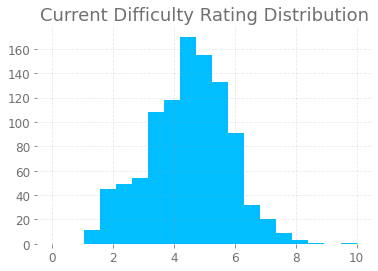

In [14]:
bins = np.linspace(0,10, 20)
df_sorted_bm_with_rating.hist(column = 'Difficulty rating', bins = bins)
plt.title("Current Difficulty Rating Distribution")

## Finding Scaled Average Score for Each Beatmap
**Method:** In order to compare beatmaps using existing player score data, we decided to scale all scores to be in between the range of 0 to 1, and proceeded to take the average of all the scaled scores for each beatmap. This average number will represent our comparison point for winning and losing in the ELO algorithm.

In [31]:
# scaled difficulty ratings
def get_bm_scores(id_):
    beatmap_scores = list(scores_high.find({'beatmap_id': id_}, {'_id': 0, 'score':1}))
    scores_df = pd.DataFrame.from_dict(beatmap_scores)
    scores_df = (scores_df - scores_df.min()) / (scores_df.max() - scores_df.min())
    return np.mean(scores_df)[0]

## Implementing Elo Rating System
**Brief Description:** The ELO rating system algorithm is a method for calculating the relative skill levels of players in zero-sum games. It is used in a variety of fields such as Chess and Basketball. For our purposes, we implemented the algorithm to change the beatmap difficulty scores based off of player scores. 


**ELO Process:** The ELO rating in our case is the scaled beatmaps average score. The difference in the ELO rating serves as a predictor of the outcome of a match-up between two beatmaps. ELO is based on pair-wise comparisons; after every match, the winning beatmap takes points from the losing beatmap. The difference between the ELO rating of the winner and loser determines the total number of points gained or lost after a match-up. If the outcome is as predicted, only a few points are added to the winner's rating/taken from the loser's rating. We took the 1000 most popular beatmaps and ran through every possible match-up to finalize our ELO ratings, which represent our new beatmap difficulty scores. 

We scaled the existing beatmap difficulty ratings by a factor of 300 in order to implement the ELO algorithm because the average ELO score is usually around 1500, based off our research. 

We also randomized the order of beatmaps in our dataframe because the pairwise comparisons are performed sequentially, so the order matters. 

In [17]:
df_sorted_bm_with_rating['Scaled Difficulty Rating'] = df_sorted_bm_with_rating['Difficulty rating'] * 300
df_sorted_bm_with_rating = df_sorted_bm_with_rating.sample(frac = 1).reset_index()

In [18]:
df_sorted_bm_with_rating.head()

,index,Beatmap id,playcount,Difficulty rating,Scaled Difficulty Rating
0,901,1265800,1965371,5.26747,1580.241
1,277,1623092,4049523,5.32394,1597.182
2,306,96006,3817196,3.76242,1128.726
3,461,1093244,3043007,2.37495,712.485
4,191,828806,4838457,5.28375,1585.125


In [57]:
bm_ratings_dict = dict(zip(df_sorted_bm_with_rating['Beatmap id'], df_sorted_bm_with_rating['Scaled Difficulty Rating']))
bm_ratings_dict

{229493: 1454.754,
 795627: 1809.6239999999998,
 1071242: 1707.687,
 871027: 1310.775,
 2444149: 1755.57,
 675330: 1384.092,
 41139: 1132.479,
 804882: 955.881,
 828806: 1585.1250000000002,
 507728: 1477.788,
 1258440: 1398.7230000000002,
 1083055: 1519.821,
 110175: 1110.1889999999999,
 538215: 1287.888,
 1988749: 1077.435,
 690778: 1597.4370000000001,
 422328: 1833.624,
 1013310: 1189.8239999999998,
 602973: 1444.326,
 1503470: 1517.4750000000001,
 760034: 1070.664,
 1514898: 1517.301,
 171126: 1311.795,
 910147: 1832.0759999999998,
 1827323: 1722.672,
 374114: 1451.946,
 239265: 1251.63,
 1799197: 1816.5839999999998,
 827803: 1849.143,
 663819: 1296.348,
 145366: 1246.3919999999998,
 1278814: 1365.9,
 1033154: 1425.6,
 930249: 1879.7189999999998,
 187590: 704.211,
 1610994: 1617.399,
 315552: 1093.206,
 827488: 1719.0990000000002,
 1618411: 1404.633,
 1094076: 1056.156,
 534080: 986.385,
 1128411: 1962.024,
 2223144: 1527.0240000000001,
 833638: 1270.3020000000001,
 1677119: 1259.44

In [60]:
import math

def find_winner(score_a, score_b):
    if score_a < score_b: 
        return 1 # A wins
    else: 
        return 0 # B wins

# Function to calculate the probability of winning
def Probability(ra, rb):
    return 1.0 * 1.0 / (1 + 1.0 * math.pow(10, 1.0 * (ra - rb) / 400))

# Function to adjust Elo rating
# K is a constant.
# d determines whether Player A wins or Player B.
def EloRating(Ra, Rb, K, d):
    # To calculate the Winning Probability of Player B
    Pb = Probability(Ra, Rb)
    # To calculate the Winning Probability of Player A
    Pa = Probability(Rb, Ra)
    # Case - 1: When Player A wins, increase A Elo Ratings
    if (d == 1) :
        Ra = Ra + K * (1 - Pa)
        Rb = Rb + K * (0 - Pb)
    # Case - 2: When Player B wins, increase B Elo Ratings
    else :
        Ra = Ra + K * (0 - Pa)
        Rb = Rb + K * (1 - Pb)
    return (round(Ra, 6), round(Rb, 6))

# This code is contributed by Smitha Dinesh Semwal

Below, we looped through every possible match-up with 1000 beatmaps and adjusted the ELO ratings accordingly.

In [19]:
# K = 30
# for pair in tqdm(itertools.combinations(list(bm_ratings_dict.keys()),2)):
#     try:
#         score_a = get_bm_scores(pair[0])
#         score_b = get_bm_scores(pair[1])
#         Ra = df_sorted_bm_with_rating.loc[df_sorted_bm_with_rating['Beatmap id'] == pair[0]]['Scaled Difficulty Rating'].iloc[0]
#         Rb = df_sorted_bm_with_rating.loc[df_sorted_bm_with_rating['Beatmap id'] == pair[1]]['Scaled Difficulty Rating'].iloc[0]
#         d = find_winner(score_a, score_b)
#         Ra, Rb = EloRating(Ra, Rb, K, d)
#         bm_ratings_dict[pair[0]] = Ra
#         bm_ratings_dict[pair[1]] = Rb 
#     except:
#         continue

## New Difficulty Ratings

We rescaled our ELO ratings down by 300, so that the range of beatmap difficulty scores is roughly between 0 and 10, similar to the original beatmap difficulty scores.

In [21]:
df_new_bm_difficulty = pd.read_csv('output.csv', header = None, names = ["Beatmap id", "Scaled Difficulty Rating"])
df_new_bm_difficulty['New Difficulty Rating'] = df_new_bm_difficulty['Scaled Difficulty Rating'] / 300
df_new_bm_difficulty

,Beatmap id,Scaled Difficulty Rating,New Difficulty Rating
0,882805,862.821231,2.876071
1,446612,1337.527653,4.458426
2,63559,1120.243709,3.734146
3,375836,1343.025446,4.476751
4,985141,1869.791638,6.232639
...,...,...,...
995,896855,1286.630038,4.288767
996,969681,1754.165165,5.847217
997,1192807,2119.310323,7.064368
998,1677119,1249.231805,4.164106


## Data Visualizations

Text(0.5, 1.0, 'New Difficulty Rating Distribution')

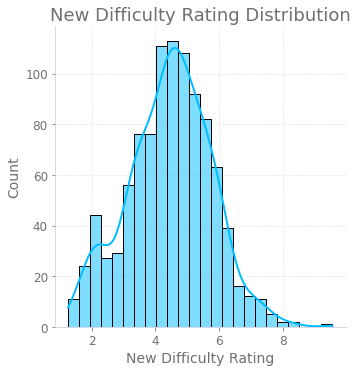

In [7]:
sns.displot(data = df_new_bm_difficulty, x = 'New Difficulty Rating', kde = True)
plt.title('New Difficulty Rating Distribution')

Text(0.5, 1.0, 'Old Difficulty Rating Distribution')

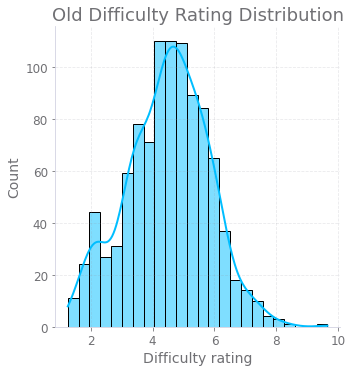

In [25]:
sns.displot(data = df_sorted_bm_with_rating, x = 'Difficulty rating', kde = True)
plt.title('Old Difficulty Rating Distribution')

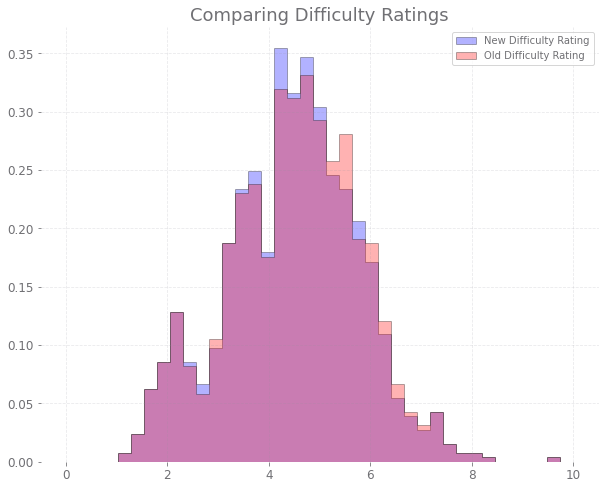

In [30]:
plt.figure(figsize=(10,8))
bins = np.linspace(0, 10, 40)
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=bins, edgecolor = 'black')
plt.hist(df_new_bm_difficulty['New Difficulty Rating'], **kwargs, color = 'blue',label='New Difficulty Rating')
plt.hist(df_sorted_bm_with_rating['Difficulty rating'], **kwargs, color = "red",label='Old Difficulty Rating')

plt.legend(loc='upper right')
plt.title('Comparing Difficulty Ratings')
plt.show()

## Examining the Difference Between Old and New Beatmap Difficulty Scores

In [46]:
old_ratings = df_sorted_bm_with_rating[['Difficulty rating', 'Beatmap id']]
new_ratings = df_new_bm_difficulty[['New Difficulty Rating', 'Beatmap id']]

df_ratings = new_ratings.merge(old_ratings, on = 'Beatmap id')

columns = ['Beatmap id', 'Difficulty rating', 'New Difficulty Rating']
df_ratings = df_ratings[columns]
df_ratings

,Beatmap id,Difficulty rating,New Difficulty Rating
0,882805,2.88111,2.876071
1,446612,4.50514,4.458426
2,63559,3.75346,3.734146
3,375836,4.52429,4.476751
4,985141,6.22713,6.232639
...,...,...,...
995,896855,4.32800,4.288767
996,969681,5.93846,5.847217
997,1192807,7.06301,7.064368
998,1677119,4.19814,4.164106


In [50]:
# Calculating average change in difficulty scores
diff_in_ratings = abs(df_ratings['Difficulty rating'] - df_ratings['New Difficulty Rating'])
avg_difference = np.mean(diff_in_ratings)
avg_difference

0.04262019306333335

In [54]:
df_ratings['Differences'] = df_ratings['Difficulty rating'] - df_ratings['New Difficulty Rating']
df_ratings

,Beatmap id,Difficulty rating,New Difficulty Rating,Differences
0,882805,2.88111,2.876071,0.005039
1,446612,4.50514,4.458426,0.046714
2,63559,3.75346,3.734146,0.019314
3,375836,4.52429,4.476751,0.047539
4,985141,6.22713,6.232639,-0.005509
...,...,...,...,...
995,896855,4.32800,4.288767,0.039233
996,969681,5.93846,5.847217,0.091243
997,1192807,7.06301,7.064368,-0.001358
998,1677119,4.19814,4.164106,0.034034


We wanted to plot the differences between the old and new beatmap difficulty scores in order to see if beatmap scores were consistently being either underrated or overrated, but that is not what we saw in the scatterplot below. 

Text(0.5, 1.0, 'Difficulty Rating Differences')

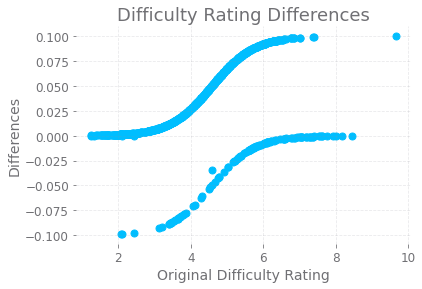

In [61]:
plt.scatter(df_ratings['Difficulty rating'], df_ratings['Differences'])
plt.xlabel('Original Difficulty Rating')
plt.ylabel('Differences')
plt.title('Difficulty Rating Differences')